In [1]:
# !pip install tensorflow==2.15.0
# !pip install tf_keras==2.15.0

In [2]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import Embedding
from src.recommender import RecommenderModel
from src.retrieval import Retrieval
from src.ranking.pointwise import PointwiseRanking
from src.ranking.listwise import ListwiseRanking
from src.utils.utilities import (
    parquet_to_Dataset,
    train_test_split,
    plot_history,
    sample_listwise,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

2024-09-03 17:12:39.317315: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 17:12:39.784248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 17:12:39.784311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 17:12:39.885197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 17:12:40.087589: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 17:12:40.090399: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
# Load ratings dataset
ratings_dataset = parquet_to_Dataset(
    path = 'data/100k-ratings.parquet',
    exclude_columns = ['movie_genres'],
    count = 100_000
)

# Load movies dataset
movies_dataset = parquet_to_Dataset(
    path = 'data/100k-movies.parquet',
    exclude_columns = ['movie_genres'],
    count = 100_000
)

2024-09-03 17:12:45.119522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-03 17:12:45.119996: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Dataset Splitting

In [5]:
# Split ratings dataset into train and validation
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [6]:
# ratings_trainset = sample_listwise(
#     ratings_trainset,
#     num_list_per_user = 50,
#     num_examples_per_list = 5,
#     seed = RANDOM_STATE
# )

# ratings_validset = sample_listwise(
#     ratings_validset,
#     num_list_per_user = 1,
#     num_examples_per_list = 5,
#     seed = RANDOM_STATE
# )

In [7]:
# Create user embedding
user_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000_000),
    str_features = ['user_id', 'user_zip_code', 'user_occupation_text'],
    int_features = ['user_gender', 'bucketized_user_age'],
    text_features = [],
    timestamp_features = ['timestamp'],
    embedding_dim = 32,
)

# Create movie embedding
movie_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000),
    str_features = [],
    int_features = [],
    text_features = ['movie_title'],
    timestamp_features = [],
    embedding_dim = 32,
)

In [8]:
cross_layer = tfrs.layers.dcn.Cross(
    projection_dim = 32,
    kernel_initializer = "glorot_uniform"
)

candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer = cross_layer,
    dense_layers = [32]
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer = cross_layer,
    dense_layers = [32]
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates = movies_dataset.batch(128).map(candidate_tower)
)

## Pointwise Ranking Model

In [9]:
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),    # Pointwise loss
    # loss = tfr.keras.losses.PairwiseHingeLoss(),  # Pairwise loss
    # loss = tfr.keras.losses.ListMLELoss(),        # Listwise loss
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        # tfr.keras.metrics.NDCGMetric(name="ndcg_metric")
    ]
)

ranking_model = PointwiseRanking(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    task = ranking_task
)

## Retrieval Model

In [10]:
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

retrieval_model = Retrieval(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    task = retrieval_task
)

## Recommender Model

In [11]:
model = RecommenderModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    ranking_model = ranking_model,
    retrieval_model = retrieval_model,
    retrieval_weight = 0.5,
    ranking_weight = 0.5,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(optimizer = optimizer)  # NOTE: Remove 'run_eagerly=True' for production

In [12]:
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 50,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/50
79/79 [==============================] - 21s 96ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 3369.3818 - regularization_loss: 0.0000e+00 - total_loss: 3369.3818 - val_root_mean_squared_error: 1.0892 - val_factorized_top_k/top_1_categorical_accuracy: 0.0012 - val_factorized_top_k/top_5_categorical_accuracy: 0.0104 - val_factorized_top_k/top_10_categorical_accuracy: 0.0220 - val_factorized_top_k/top_50_categorical_accuracy: 0.1069 - val_factorized_top_k/top_100_categorical_accuracy: 0.2133 - val_loss: 1599.7711 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1599.7711
Epoch 2/50
79/79 [==============================] - 3s 40ms/step - root_mean_squared_error: 0.0000e+00 - f

In [13]:
model.evaluate(cached_ratings_validset, return_dict=True, verbose=False)

{'root_mean_squared_error': 0.9529379606246948,
 'factorized_top_k/top_1_categorical_accuracy': 0.00044999999227002263,
 'factorized_top_k/top_5_categorical_accuracy': 0.004100000020116568,
 'factorized_top_k/top_10_categorical_accuracy': 0.010950000025331974,
 'factorized_top_k/top_50_categorical_accuracy': 0.12600000202655792,
 'factorized_top_k/top_100_categorical_accuracy': 0.2731499969959259,
 'loss': 1698.4833984375,
 'regularization_loss': 0,
 'total_loss': 1698.4833984375}

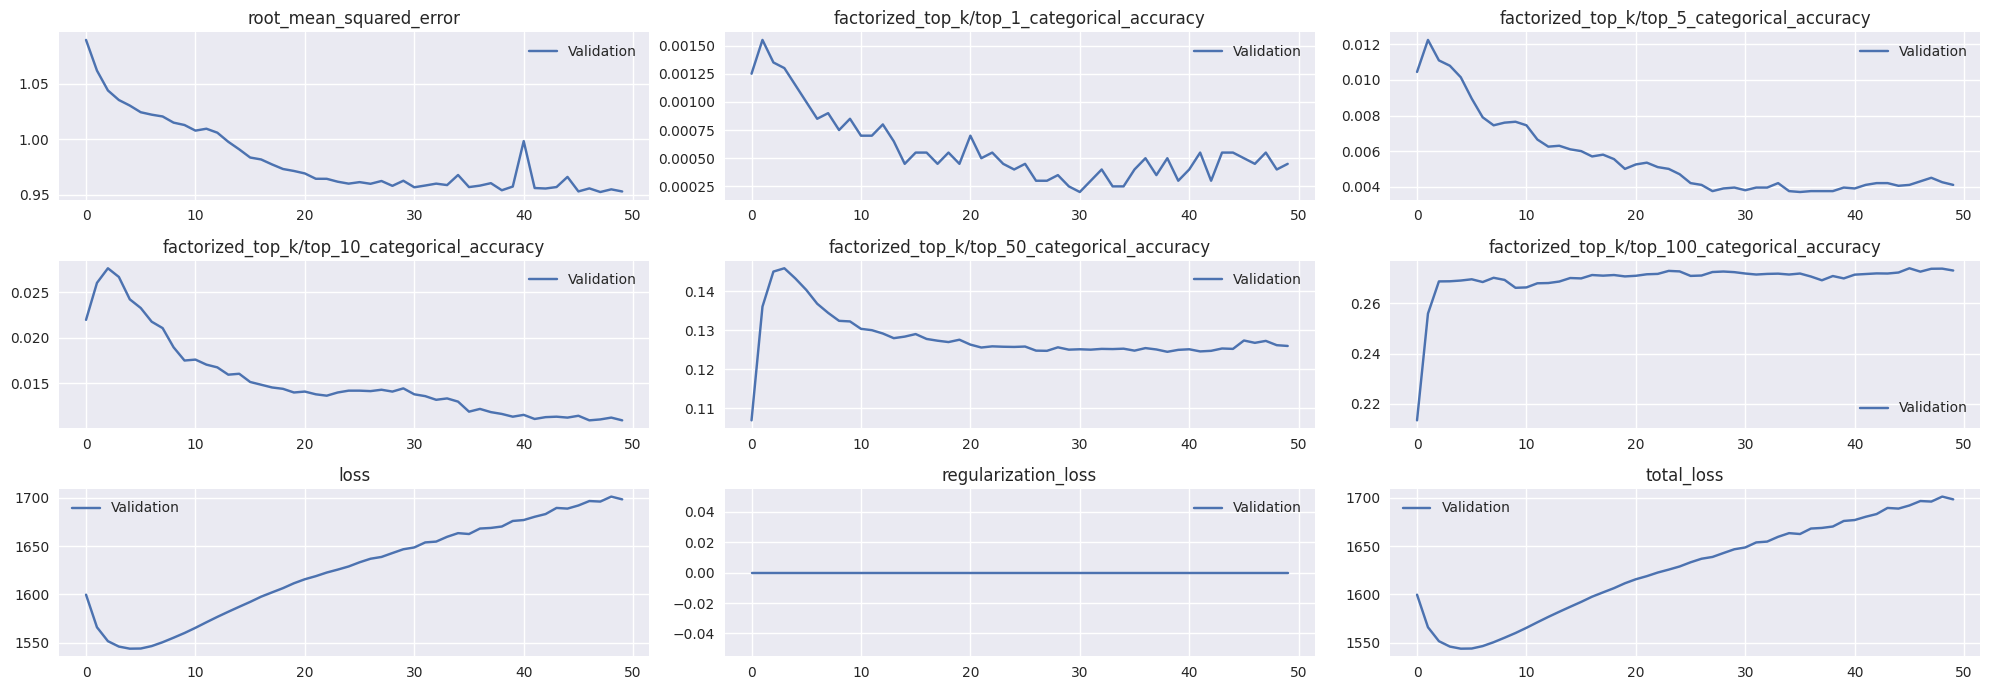

In [14]:
plot_history(history = history, plot_training=False)

In [15]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    model.query_tower,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

2024-09-03 17:16:15.517769: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-09-03 17:16:15.530295: W scann/utils/gmm_utils.cc:921] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-09-03 17:16:15.533501: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 15.658817ms.


In [16]:
index = 0
data = ratings_dataset.take(1).as_numpy_iterator().next()
data = {k: tf.convert_to_tensor([v]) for k, v in data.items()}

afinity_scores, movie_ids = scann_layer(data)

for movie_id in movie_ids[0]:

    pred = model(data)
    _, _, rating = pred

    print(f"Movie {movie_id}: {rating[0][0]}")

Movie b'483': 4.226754665374756
Movie b'134': 4.226754665374756
Movie b'657': 4.226754665374756
Movie b'87': 4.226754665374756
Movie b'484': 4.226754665374756
Movie b'357': 4.226754665374756
Movie b'192': 4.226754665374756
Movie b'191': 4.226754665374756
Movie b'474': 4.226754665374756
Movie b'287': 4.226754665374756
